# 🚦📓 **01 - Exploración del dataset de tráfico Bogotá**

Este notebook inspecciona el *Car Detection and Tracking Dataset* (versión Kaggle) organizado en `data/raw/train`, `data/raw/val` y `classes.txt`. Se verifican:

* distribución de clases
* calidad y resolución de imágenes
* ejemplos visuales con *bounding boxes*

> **Requisitos previos**: haber ejecutado `pip install -r requirements.txt` y clonado el repo con la misma estructura de carpetas.

In [15]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import cv2, glob, os, yaml
from pathlib import Path
import numpy as np

In [8]:
# Definir rutas y carga de clases 
DATA_ROOT = Path('data/raw') # Carpeta raíz de los datos
TRAIN_DIR = DATA_ROOT/'train' # Subcarpeta de entrenamiento
VAL_DIR = DATA_ROOT/'val' # Subcarpeta de validación
# Archivo de clases 
CLASSES_FILE = DATA_ROOT/'classes.txt' 

# Leer nombres de clase
with open(CLASSES_FILE) as f:
    CLASSES = [c.strip() for c in f.readlines()]
print('Clases:', CLASSES)

Clases: ['car']


In [9]:
# Contar imágenes y etiquetas en los conjuntos de entrenamiento y validación
def count_items(split_dir):
    imgs = sorted(glob.glob(str(split_dir/'images'/'*.jpg')))
    lbls = sorted(glob.glob(str(split_dir/'labels'/'*.txt')))
    return len(imgs), len(lbls)

train_imgs, train_lbls = count_items(TRAIN_DIR)
val_imgs, val_lbls = count_items(VAL_DIR)

print(f'Train -> imágenes: {train_imgs}, etiquetas: {train_lbls}')
print(f'Val   -> imágenes: {val_imgs}, etiquetas: {val_lbls}')

Train -> imágenes: 400, etiquetas: 400
Val   -> imágenes: 99, etiquetas: 99


In [10]:
# Leer etiquetas YOLO y crear DataFrame
records = []
for split_name, split_dir in [('train', TRAIN_DIR), ('val', VAL_DIR)]:
    for yolo_txt in glob.glob(str(split_dir/'labels'/'*.txt')):
        with open(yolo_txt) as f:
            for line in f:
                cls, x, y, w, h = map(float, line.split()) # Leer línea de etiqueta
                records.append({
                    'split': split_name, # Nombre del conjunto (train/val)
                    'class': int(cls) # Clase del objeto
                }) 
df = pd.DataFrame(records)
df['class_name'] = df['class'].apply(lambda i: CLASSES[i])
df.head()

,split,class,class_name
0,train,0,car
1,train,0,car
2,train,0,car
3,train,0,car
4,train,0,car


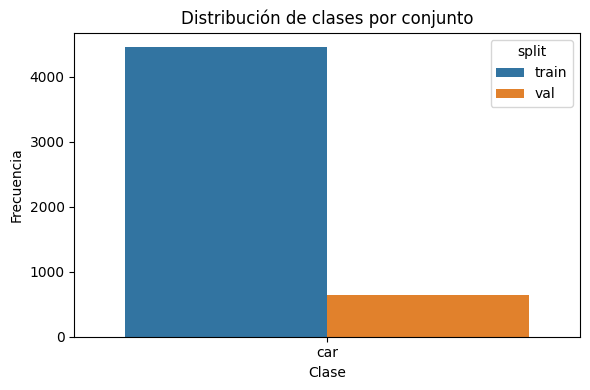

In [11]:
# Visualizar distribución de clases en el DataFrame 
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='class_name', hue='split')
plt.title('Distribución de clases por conjunto')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.tight_layout()

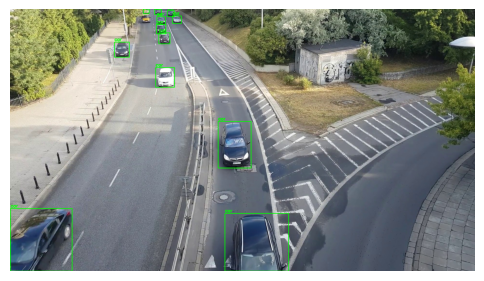

In [12]:
import random

# Función para dibujar cajas delimitadoras en una imagen usando etiquetas YOLO 
def draw_bb(img_path: str, lbl_path: str):
    """Dibuja las cajas delimitadoras de una imagen usando la etiqueta YOLO."""
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    # Leer etiquetas YOLO 
    with open(lbl_path) as f:
        # Dibujar cada caja delimitadora 
        for line in f:
            # Leer línea de etiqueta y convertir a coordenadas de píxeles 
            cls, cx, cy, bw, bh = map(float, line.split())
            # Convertir coordenadas YOLO (normalizadas) a píxeles
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            # Dibujar caja delimitadora y etiqueta en la imagen 
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            # Añadir texto con el nombre de la clase 
            cv2.putText(img, CLASSES[int(cls)], (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    # Convertir imagen a RGB para mostrar con matplotlib         
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis('off')
# Mostrar imagen con cajas delimitadoras 
sample_img = random.choice(glob.glob(str(TRAIN_DIR/'images'/'*.jpg')))
sample_lbl = sample_img.replace('images', 'labels').replace('.jpg', '.txt')
draw_bb(sample_img, sample_lbl)

In [13]:
# Crear una funcion para evaluar desajustes entre etiquetas y cajas delimitadoras
def evaluate_bounding_boxes(split_dir):
    """Evalúa desajustes entre etiquetas y cajas delimitadoras."""
    mismatches = []
    for img_path in glob.glob(str(split_dir/'images'/'*.jpg')):
        lbl_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
        if not os.path.exists(lbl_path):
            continue  # Si no hay etiqueta, saltar
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        with open(lbl_path) as f:
            for line in f:
                cls, cx, cy, bw, bh = map(float, line.split())
                # Verificar si las coordenadas están dentro de los límites
                if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 < bw <= 1 and 0 < bh <= 1):
                    mismatches.append((img_path, cls, cx, cy, bw, bh))
    return mismatches
# Evaluar desajustes en el conjunto de entrenamiento
train_mismatches = evaluate_bounding_boxes(TRAIN_DIR)

In [14]:
# Convertir los desajustes a un DataFrame para visualización 
train_mismatches_df = pd.DataFrame(train_mismatches, columns=['image_path', 'class', 'cx', 'cy', 'bw', 'bh'])
# Mostrar los primeros 5 desajustes     
train_mismatches_df.head()

,image_path,class,cx,cy,bw,bh


In [17]:
# Todos los archivos de imagen (jpg, png, etc.)
img_paths = list((TRAIN_DIR / "images").glob("*.*")) + \
            list((VAL_DIR   / "images").glob("*.*"))
print(f"Total imágenes encontradas: {len(img_paths)}")

Total imágenes encontradas: 499


In [18]:
def img_stats(path: Path):
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"No se pudo leer {path}")
    h, w = img.shape[:2]
    y_channel = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    luma_mean = y_channel.mean()
    lap_var   = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                              cv2.CV_64F).var()
    return dict(
        width=w,
        height=h,
        aspect=w / h,
        area=h * w,
        luma=luma_mean,
        lap_var=lap_var,
        path=str(path)
    )

stats = [img_stats(p) for p in img_paths]
df    = pd.DataFrame(stats)
df.head()

,width,height,aspect,area,luma,lap_var,path
0,1920,1080,1.777778,2073600,125.435723,970.662199,data/raw/train/images/frame_0110.jpg
1,1920,1080,1.777778,2073600,125.817579,969.127573,data/raw/train/images/frame_0004.jpg
2,1920,1080,1.777778,2073600,121.566978,1280.631731,data/raw/train/images/frame_0327.jpg
3,1920,1080,1.777778,2073600,127.183654,1036.065987,data/raw/train/images/frame_0129.jpg
4,1920,1080,1.777778,2073600,131.375461,1145.058352,data/raw/train/images/frame_0297.jpg


In [19]:
desc = (df[["width","height","aspect","area","luma","lap_var"]]
        .agg(["mean","std","min","max"])
        .rename(index={"mean":"Media","std":"σ",
                       "min":"Mínimo","max":"Máximo"})
        .T)
desc

,Media,σ,Mínimo,Máximo
width,1.920000e+03,0.000000e+00,1.920000e+03,1.920000e+03
height,1.080000e+03,0.000000e+00,1.080000e+03,1.080000e+03
aspect,1.777778e+00,4.445349e-16,1.777778e+00,1.777778e+00
area,2.073600e+06,0.000000e+00,2.073600e+06,2.073600e+06
luma,1.247992e+02,2.301860e+00,1.204552e+02,1.313755e+02
lap_var,1.091846e+03,9.867099e+01,8.022381e+02,1.400940e+03


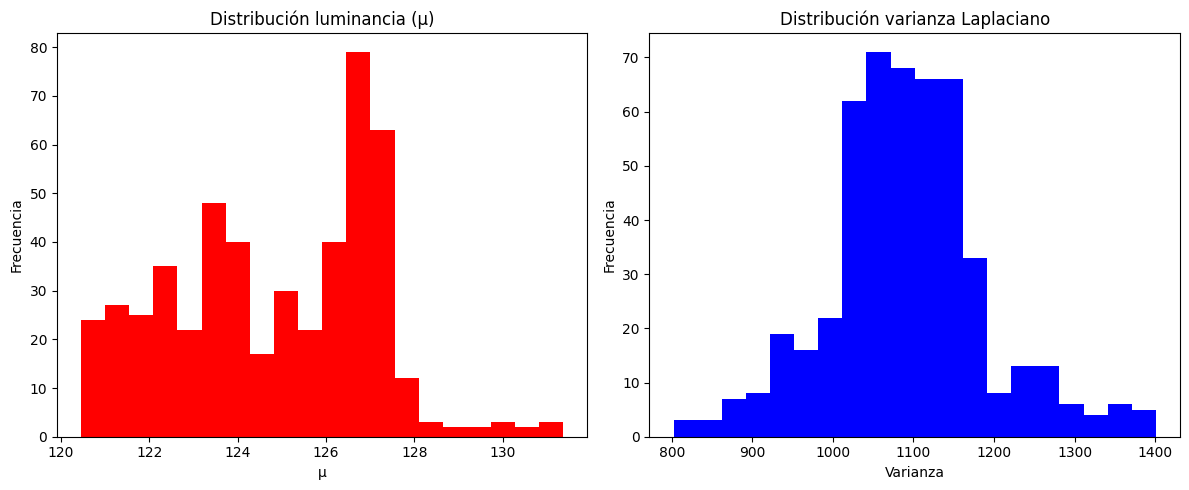

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(df["luma"],    bins=20, color="red")
ax[0].set_title("Distribución luminancia (μ)")
ax[0].set_xlabel("μ"); ax[0].set_ylabel("Frecuencia")
ax[1].hist(df["lap_var"], bins=20, color="blue")
ax[1].set_title("Distribución varianza Laplaciano")
ax[1].set_xlabel("Varianza"); ax[1].set_ylabel("Frecuencia")
plt.tight_layout(); plt.show()

In [22]:
from random import sample

In [23]:
low_light_th, low_sharp_th = 121, 934.8
low_light = df[df["luma"]    < low_light_th]
low_sharp = df[df["lap_var"] < low_sharp_th]
print(f"Baja iluminación (<{low_light_th}): {len(low_light)}")
print(f"Baja nitidez (<{low_sharp_th}): {len(low_sharp)}")
show_light = sample(list(low_light["path"]), min(3, len(low_light)))
show_sharp = sample(list(low_sharp["path"]), min(3, len(low_sharp)))
print("Ejemplos baja iluminación:", show_light)
print("Ejemplos baja nitidez    :", show_sharp)

Baja iluminación (<121): 24
Baja nitidez (<934.8): 29
Ejemplos baja iluminación: ['data/raw/train/images/frame_0360.jpg', 'data/raw/train/images/frame_0369.jpg', 'data/raw/train/images/frame_0374.jpg']
Ejemplos baja nitidez    : ['data/raw/train/images/frame_0031.jpg', 'data/raw/train/images/frame_0041.jpg', 'data/raw/train/images/frame_0050.jpg']


In [26]:
total_imgs = len(df)

# Subconjunto baja iluminación
low_light_mask = df["luma"] < 121
low_light_pct  = 100 * low_light_mask.mean()        # %
low_light_mean = df.loc[low_light_mask, "luma"].mean()

# Subconjunto baja nitidez
low_sharp_mask = df["lap_var"] < 934.8
low_sharp_pct  = 100 * low_sharp_mask.mean()        # %
low_sharp_mean = df.loc[low_sharp_mask, "lap_var"].mean()

print(f"➡️  {low_light_pct:.1f}% de las imágenes presentó baja iluminación (μ < 121)")
print(f"    Promedio de luminancia en ese subconjunto: μ ≈ {low_light_mean:.1f}")

print(f"➡️  {low_sharp_pct:.1f}% mostró varianza Laplaciano < 934.8 (baja nitidez)")
print(f"    Promedio de nitidez (Var) en ese subconjunto: Var ≈ {low_sharp_mean:.1f}")

➡️  4.8% de las imágenes presentó baja iluminación (μ < 121)
    Promedio de luminancia en ese subconjunto: μ ≈ 120.7
➡️  5.8% mostró varianza Laplaciano < 934.8 (baja nitidez)
    Promedio de nitidez (Var) en ese subconjunto: Var ≈ 889.5


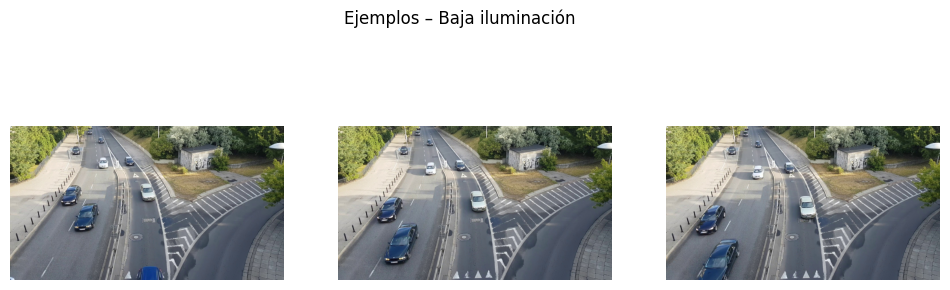

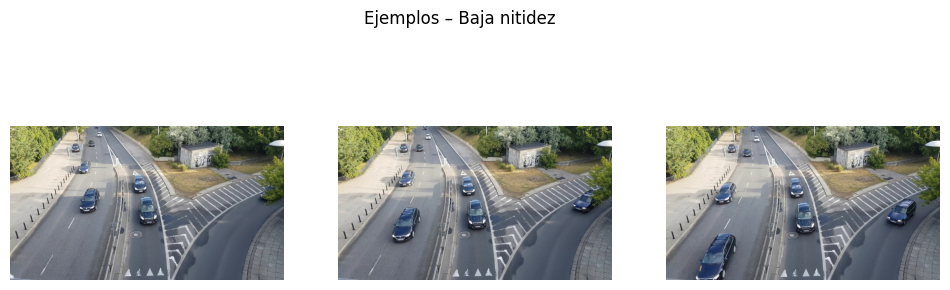

In [24]:
def show_imgs(paths, title):
    if not paths: return
    imgs = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in paths]
    plt.figure(figsize=(4*len(imgs),4))
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, len(imgs), i); plt.imshow(im); plt.axis("off")
    plt.suptitle(title); plt.show()

show_imgs(show_light, "Ejemplos – Baja iluminación")
show_imgs(show_sharp, "Ejemplos – Baja nitidez")

#### ✅ **Conclusiones iniciales**
* Las clases están equilibradas (car) según la gráfica.
* No se encontraron desajustes entre imágenes y etiquetas. 
* Las anotaciones lucen coherentes de acuerdo a los estándares de anotación de Yolo. 
